In [2]:
import os
import sys
import inspect 
import time
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import weierstrass as weier
from runs.runs_entropy import RRLoader,RRLoaderShuffled, Signal, Runs
import seaborn as sns
import statsmodels.api as sm

In [38]:
def biased_random_walk(n_steps, p_forward):
    """
    Generate a biased random walk with limited step sizes.

    Parameters:
    n_steps (int): Number of steps in the random walk
    p_forward (float): Probability of moving forward

    Returns:
    numpy.array: Array of positions at each step
    """
    # Initialize the time series
    X = np.zeros(n_steps + 1)

    for t in range(n_steps):
        # Choose direction
        if np.random.random() < p_forward:
            # Move forward
            step = np.random.uniform(0, 0.5)
        else:
            # Move backward
            step = np.random.uniform(-0.5, 0)

        # Update position
        X[t + 1] = X[t] + step

    return X

def get_entropy_df(num_samples, n_steps, p_forward):
    har, hdr, hno = [], [], []

    for _ in range(num_samples):
        signal_data = biased_random_walk(n_steps, p_forward)
        annotations = np.zeros(len(signal_data))
        signal = Signal(signal_data, annotations=annotations)
        
        runs = Runs(signal)
        har.append(runs.HAR)
        hdr.append(runs.HDR)
        hno.append(runs.HNO)
    
    return pd.DataFrame(np.array([har, hdr, hno]).T, columns=['HAR', 'HDR', 'HNO'])

def perform_binomial_tests_and_plot(df,num_samples, p_forward,only_test = False):        
    # Perform binomial test
    har_values = df['HAR'] 
    #har_count = har_values.sum()
    hdr_values = df['HDR']
    #hdr_count = hdr_values.sum()
    #total_count = har_count + hdr_count
    har_bigger = np.count_nonzero(har_values > hdr_values) #sum([1 if har > hdr else 0 for har,hdr in zip(har_values,hdr_values)])
    print(har_bigger)
    p_value = stats.binom_test(har_bigger, n=num_samples, p=0.5)

    print(f"Binomial test p-value: {p_value:.4f}")

    #w_statistic, p_value_wilcoxon = stats.ttest_rel(har_values, hdr_values)
    #print(f"Wilcoxon test p-values: {p_value_wilcoxon:.4f}")
    if only_test:
        return p_value
    
    # Plot boxplot
    plt.figure(figsize=(8, 6))
    df.boxplot(column=['HAR', 'HDR'])
    plt.title(f"Boxplot of HAR and HDR (random walk with bias for p_forward : {p_forward})")
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

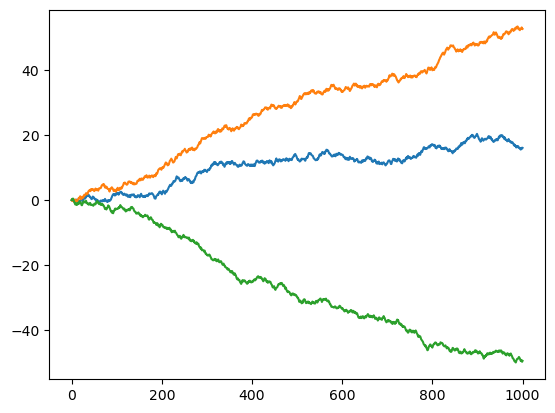

In [7]:
random_sample_1 = biased_random_walk(1000,0.5)
random_sample_2 = biased_random_walk(1000,0.6)
random_sample_3 = biased_random_walk(1000,0.4)

plt.plot(random_sample_1)
plt.plot(random_sample_2)
plt.plot(random_sample_3)

In [30]:
entropy_df = get_entropy_df(100, 1000, 0.5)

In [31]:
entropy_df

,HAR,HDR,HNO
0,1.124088,1.463412,0.0
1,1.326617,1.258123,0.0
2,1.330767,1.194188,0.0
3,1.241551,1.257210,0.0
4,1.256127,1.283884,0.0
...,...,...,...
95,1.281024,1.214141,0.0
96,1.271687,1.193254,0.0
97,1.199803,1.271971,0.0
98,1.189988,1.327625,0.0


50
Binomial test p-value: 1.0000


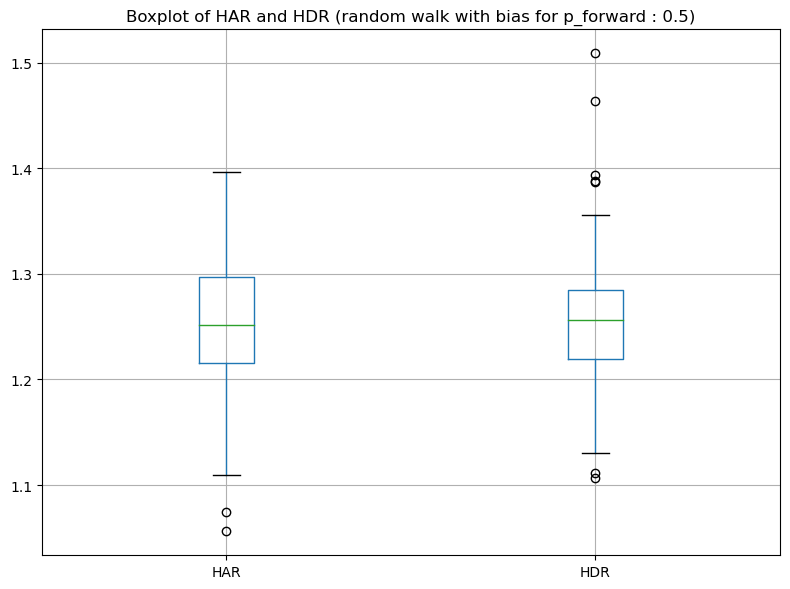

In [32]:
perform_binomial_tests_and_plot(entropy_df,num_samples=100, p_forward=0.5)

100
Binomial test p-value: 0.0000


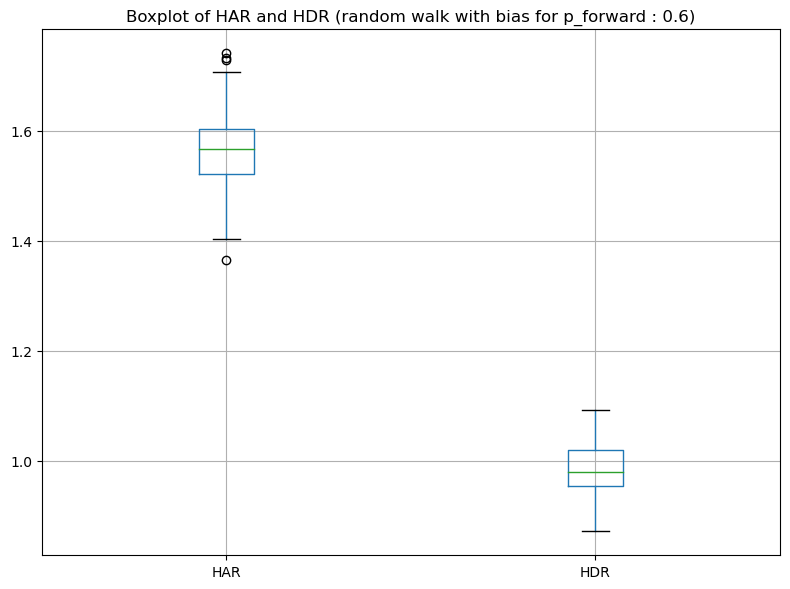

In [34]:
entropy_df_pf06 = get_entropy_df(100, 1000, 0.6)
perform_binomial_tests_and_plot(entropy_df_pf06,num_samples=100, p_forward=0.6)

0
Binomial test p-value: 0.0000


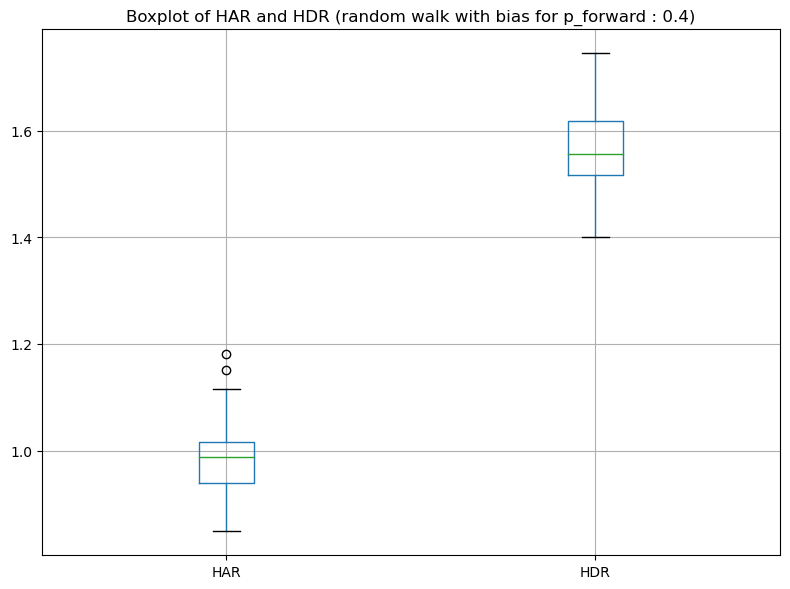

In [35]:
entropy_df_pf04 = get_entropy_df(100, 1000, 0.4)
perform_binomial_tests_and_plot(entropy_df_pf04,num_samples=100, p_forward=0.4)

In [42]:
def iterate_entropy_and_binomial_tests(num_samples, n_steps, p_forward=0.5, epsilon=0.01):
    while p_forward <= 1.0:
        # Step 1: Call get_entropy_df with the current p_forward
        df = get_entropy_df(num_samples, n_steps, p_forward)

        # Step 2: Call perform_binomial_tests_and_plot with the DataFrame returned by get_entropy_df
        p_value = perform_binomial_tests_and_plot(df, num_samples, p_forward, only_test=True)

        # Step 3: Check the p-value result
        if p_value < 0.05:
            print(f"Stopping: p_value={p_value}, p_forward={p_forward}")
            break
        
        # Step 4: Increment p_forward by epsilon if p_value is greater than 0.05
        p_forward += epsilon

    if p_forward > 1.0:
        print("p_forward reached 1 without finding a significant p_value.")

In [ ]:
### Szukamy dla jakiej wartości p_forward HAR > HDR będzie statystyczneie istotne

In [43]:
iterate_entropy_and_binomial_tests(100,1000,epsilon=0.001) 

52
Binomial test p-value: 0.7644
58
Binomial test p-value: 0.1332
44
Binomial test p-value: 0.2713
53
Binomial test p-value: 0.6173
51
Binomial test p-value: 0.9204
59
Binomial test p-value: 0.0886
67
Binomial test p-value: 0.0009
Stopping: p_value=0.0008737198369123724, p_forward=0.506


In [44]:
iterate_entropy_and_binomial_tests(50,1000,epsilon=0.001)

28
Binomial test p-value: 0.4799
29
Binomial test p-value: 0.3222
25
Binomial test p-value: 1.0000
30
Binomial test p-value: 0.2026
26
Binomial test p-value: 0.8877
28
Binomial test p-value: 0.4799
32
Binomial test p-value: 0.0649
30
Binomial test p-value: 0.2026
40
Binomial test p-value: 0.0000
Stopping: p_value=2.3861331676755526e-05, p_forward=0.508


In [45]:
iterate_entropy_and_binomial_tests(100,100,epsilon=0.001)

53
Binomial test p-value: 0.6173
57
Binomial test p-value: 0.1933
47
Binomial test p-value: 0.6173
55
Binomial test p-value: 0.3682
45
Binomial test p-value: 0.3682
49
Binomial test p-value: 0.9204
52
Binomial test p-value: 0.7644
51
Binomial test p-value: 0.9204
64
Binomial test p-value: 0.0066
Stopping: p_value=0.006637120515926128, p_forward=0.508


In [48]:
def iterate_entropy_and_binomial_tests_for_n_steps(num_samples, n_steps, p_forward=0.5, epsilon=0.01):
    while p_forward <= 1.0:
        # Step 1: Call get_entropy_df with the current p_forward
        df = get_entropy_df(num_samples, n_steps, p_forward)

        # Step 2: Call perform_binomial_tests_and_plot with the DataFrame returned by get_entropy_df
        p_value = perform_binomial_tests_and_plot(df, num_samples, p_forward, only_test=True)

        # Step 3: Check the p-value result
        if p_value < 0.05:
            print(f"Stopping: p_value={p_value}, p_forward={p_forward}, n_steps={n_steps}")
            break
        
        # Step 4: Increment p_forward by epsilon if p_value is greater than 0.05
        n_steps += 1

    if p_forward > 1.0:
        print("p_forward reached 1 without finding a significant p_value.")

In [ ]:
### Szukamy dla jakiej długości sygnału <n_steps> HAR > HDR będzie statystyczneie istotne

In [52]:
iterate_entropy_and_binomial_tests(1000,100,epsilon=0.001)

500
Binomial test p-value: 1.0000
505
Binomial test p-value: 0.7760
489
Binomial test p-value: 0.5067
502
Binomial test p-value: 0.9244
478
Binomial test p-value: 0.1739
486
Binomial test p-value: 0.3932
478
Binomial test p-value: 0.1739
519
Binomial test p-value: 0.2420
474
Binomial test p-value: 0.1067
497
Binomial test p-value: 0.8744
508
Binomial test p-value: 0.6353
509
Binomial test p-value: 0.5909
492
Binomial test p-value: 0.6353
527
Binomial test p-value: 0.0937
499
Binomial test p-value: 0.9748
523
Binomial test p-value: 0.1547
469
Binomial test p-value: 0.0537
485
Binomial test p-value: 0.3591
513
Binomial test p-value: 0.4292
512
Binomial test p-value: 0.4670
502
Binomial test p-value: 0.9244
497
Binomial test p-value: 0.8744
511
Binomial test p-value: 0.5067
508
Binomial test p-value: 0.6353
521
Binomial test p-value: 0.1948
528
Binomial test p-value: 0.0819
504
Binomial test p-value: 0.8248
530
Binomial test p-value: 0.0620
509
Binomial test p-value: 0.5909
484
Binomial t

In [57]:
iterate_entropy_and_binomial_tests(1000,10,epsilon=0.001)

506
Binomial test p-value: 0.7280
427
Binomial test p-value: 0.0000
Stopping: p_value=4.368916873881531e-06, p_forward=0.5, n_steps=11
